In [20]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, IndexedGraphs, Statistics, InvertedIndices
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [21]:
include("../../telegram/notifications.jl");

In [31]:
T = 100
N = 10^2
k = 4
λ = 0.015
ρ = 0.025
γ = 10/N;

In [32]:
svd_trunc = TruncBond(5)
require_convergence = true
maxiter = 100;

In [33]:
nobs = round.(Int, N/10 .* LinRange(1, 9, 5))
infected_true = Vector{Int64}[]
infected_guess = Vector{Vector{Int64}}[];

In [ ]:
ninstances = 100
redirect_stdio(stdout="sis_auc.txt", stderr="sis_auc.txt") do
    @telegram "sis auc" begin

        for n in 1:ninstances
            println("Instance $n of $ninstances")
            gg = random_regular_graph(N, k)
            t = SimpleGraph(prim_mst(gg))
            g = IndexedGraph(t)
            @assert !is_cyclic(g)
            @assert is_connected(g)
            X, _ = onesample(mpbp(SIS(g, λ, ρ, T)))
            push!(infected_true, findall(isequal(INFECTED), X[:,end]))
            push!(infected_guess, Vector{Int64}[])
            for a in eachindex(nobs)
                println("\tRun $a of $(length(nobs)). $(nobs[a]) observations / $N individuals")
                bp = mpbp(SIS(g, λ, ρ, T))
                _, observed_times_nodes = draw_node_observations!(bp.ϕ, X, nobs[a], last_time=true)
                observed_nodes = [obs[1] for obs in observed_times_nodes]
                not_observed = (1:N)[Not(observed_nodes)]
                cb = CB_BP(bp; showprogress=false)
                iters, _ = iterate!(bp; maxiter, tol=1e-3, svd_trunc, cb)
                if require_convergence
                    iters == maxiter && error("BP did not converge")
                end
                b = beliefs(bp)
                push!(infected_guess[n], sort(not_observed; by=i->b[i][end][1]))
            end
        end

    end
end

Instance 1 of 100
	Run 1 of 5. 10 observations / 100 individuals


In [ ]:
aucs_avg = [mean(auc(infected_guess[n][a], infected_true[n]) for n in 1:ninstances) 
    for a in eachindex(nobs)]
aucs_std = [std(auc(infected_guess[n][a], infected_true[n]) for n in 1:ninstances) 
    for a in eachindex(nobs)] ./ sqrt(length(infected_guess)); 

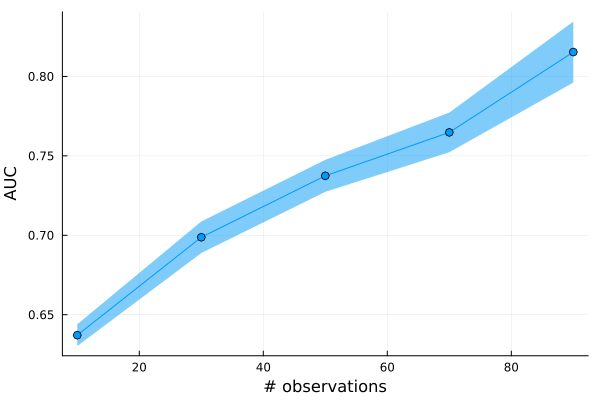

In [39]:
plot(nobs, aucs_avg, ribbon=aucs_std, xlabel="# observations", ylabel="AUC", label="", m=:o)